In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, 
                            auc, classification_report, accuracy_score, confusion_matrix, precision_score)
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.decomposition import PCA

from catboost import CatBoostClassifier

import joblib
import warnings

from pathlib import Path
import ast, json
from collections import Counter
# Настройки отображения
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.4f}'.format
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

# Первоначальный анализ данных

In [2]:
messages = pd.read_csv('/kaggle/input/ms-2-yds-dataset/apparel-messages.csv', parse_dates=["date","created_at"])
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [3]:
purchases = pd.read_csv('/kaggle/input/ms-2-yds-dataset/apparel-purchases.csv', parse_dates=["date"])
purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0000,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0000,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0000,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0000,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0000,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [4]:
target = pd.read_csv('/kaggle/input/ms-2-yds-dataset/apparel-target_binary.csv')
target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [5]:
# Функция для проверки данных
def preprocess(df):
    print('Размер датасета:', df.shape[0])
    print('\nКоличество пропусков:')
    print(df.isna().sum())
    print('\nКоличество явных дубликатов: ', df.duplicated().sum())
    
    # Создание копии набора данных 
    df_copy = df.copy()

    # Приведение к нижнему регистру и удаление пробелов для проверки неявных дубликатов
    for col in df_copy.select_dtypes(include=['object', 'category']).columns:
        df_copy[col] = df_copy[col].str.lower().str.replace(' ', '', regex=False)

    print(f'Количестов неявных дубликатов: {df_copy.duplicated().sum()}\n')

    # Удаляем копию для экономии памяти
    del df_copy

    # Проверка уникальных значений для котегориальных значений
    # for col in df.select_dtypes(include=['object', 'category']).columns:
    #     print(f'Столбец: {col} \nзначения столбца: {df[col].unique()}\n')

In [6]:
preprocess(messages)

Размер датасета: 12739798

Количество пропусков:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Количество явных дубликатов:  48610
Количестов неявных дубликатов: 48610



In [7]:
messages = messages.drop_duplicates()
preprocess(messages)

Размер датасета: 12691188

Количество пропусков:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Количество явных дубликатов:  0
Количестов неявных дубликатов: 0



In [8]:
preprocess(purchases)

Размер датасета: 202208

Количество пропусков:
client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

Количество явных дубликатов:  73020
Количестов неявных дубликатов: 73020



In [9]:
purchases = purchases.drop_duplicates()
preprocess(purchases)

Размер датасета: 129188

Количество пропусков:
client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

Количество явных дубликатов:  0
Количестов неявных дубликатов: 0



In [10]:
preprocess(target)

Размер датасета: 49849

Количество пропусков:
client_id    0
target       0
dtype: int64

Количество явных дубликатов:  0
Количестов неявных дубликатов: 0



# EDA

In [11]:
# Функция парсинга category_ids
def parse_category_ids(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        # Убираем вложенные списки
        flat_list = []
        for i in x:
            if isinstance(i, list):
                flat_list.extend([str(j) for j in i])
            else:
                flat_list.append(str(i))
        return flat_list
    s = str(x)
    # Если строка выглядит как список, попробуем literal_eval
    try:
        import ast
        parsed = ast.literal_eval(s)
        if isinstance(parsed, list):
            return [str(i) for i in parsed]
    except:
        pass
    # Разделители
    if '|' in s:
        return [p.strip() for p in s.split('|')]
    elif ',' in s:
        return [p.strip() for p in s.split(',')]
    else:
        return [s]


# Применяем парсер
purchases['category_list'] = purchases['category_ids'].apply(parse_category_ids)

# Признаки: глубина, первый и последний элемент
purchases['cat_depth'] = purchases['category_list'].apply(len)
purchases['cat_first'] = purchases['category_list'].apply(lambda x: x[0] if x else '')
purchases['cat_last'] = purchases['category_list'].apply(lambda x: x[-1] if x else '')

# Топ-N категорий
all_ids = Counter([cid for L in purchases['category_list'] for cid in L])
TOP_N_CAT = 50
most_common_ids = [cid for cid, _ in all_ids.most_common(TOP_N_CAT)]

# Флаги топ-N категорий
mlb = MultiLabelBinarizer(classes=most_common_ids)
cat_flags = pd.DataFrame(
    mlb.fit_transform(purchases['category_list']),
    columns=[f'cat_has_{c}' for c in mlb.classes_],
    index=purchases.index
)
purchases = pd.concat([purchases, cat_flags], axis=1)

# Уникальные комбинации категорий
purchases['category_set_key'] = purchases['category_list'].apply(
    lambda L: '|'.join(sorted(set(L))) if L else ''
)

print("Примеры категорий:")
print(purchases[['category_ids','category_list','cat_depth','cat_first','cat_last']].head())
print(purchases['cat_depth'].value_counts())

Примеры категорий:
                category_ids      category_list  cat_depth cat_first cat_last
0   ['4', '28', '57', '431']   [4, 28, 57, 431]          4         4      431
1   ['4', '28', '57', '431']   [4, 28, 57, 431]          4         4      431
2   ['4', '28', '57', '431']   [4, 28, 57, 431]          4         4      431
3  ['4', '28', '244', '432']  [4, 28, 244, 432]          4         4      432
4   ['4', '28', '49', '413']   [4, 28, 49, 413]          4         4      413
cat_depth
4    124747
0      2738
3       736
1       622
5       345
Name: count, dtype: int64


In [12]:
# Агрегация покупок на уровень клиента
# Расчёт суммы заказа
purchases['amount'] = purchases['quantity'] * purchases['price']
purchases['date'] = pd.to_datetime(purchases['date'])
snapshot_date = purchases['date'].max() + pd.Timedelta(days=1)

# Агрегация числовых признаков
agg_funcs = {
    'amount': ['sum','mean','std','max','min','median'],
    'quantity': ['sum','mean','std','median'],
    'price': ['mean','std','max','min'],
    'cat_depth': ['mean','max'],
}
client_agg = purchases.groupby('client_id').agg(agg_funcs)
client_agg.columns = ['_'.join(col).strip() for col in client_agg.columns.values]
client_agg = client_agg.reset_index()

# Последняя и первая покупки
last_purchase = purchases.groupby('client_id')['date'].max()
first_purchase = purchases.groupby('client_id')['date'].min()
client_agg = client_agg.merge(last_purchase.rename('last_purchase_date'), on='client_id')
client_agg = client_agg.merge(first_purchase.rename('first_purchase_date'), on='client_id')

# RFM-признаки
client_agg['recency_days'] = (snapshot_date - client_agg['last_purchase_date']).dt.days
client_agg['customer_age_days'] = (client_agg['last_purchase_date'] - client_agg['first_purchase_date']).dt.days
client_agg['purchase_count'] = purchases.groupby('client_id').size().values

# Уникальные категории и комбинации
client_agg['unique_category_ids'] = purchases.groupby('client_id')['category_list'].apply(
    lambda lists: len(set(x for L in lists for x in L))
).values
client_agg['unique_category_sets'] = purchases.groupby('client_id')['category_set_key'].nunique().values

# Агрегация топ-N категорий на уровень клиента
top_cat_cols = [c for c in purchases.columns if c.startswith('cat_has_')]
cat_agg = purchases.groupby('client_id')[top_cat_cols].sum().reset_index()
client_agg = client_agg.merge(cat_agg, on='client_id', how='left')

# Активность за окна 30/60/90 дней
WINDOWS = [30,60,90]
for w in WINDOWS:
    mask = purchases['date'] >= (snapshot_date - pd.Timedelta(days=w))
    tmp = purchases[mask].groupby('client_id').agg(
        amount_last=(('amount','sum')),
        qty_last=(('quantity','sum')),
        orders_last=(('date','count'))
    )
    tmp.columns = [f'amount_last_{w}d', f'qty_last_{w}d', f'orders_last_{w}d']
    client_agg = client_agg.merge(tmp, on='client_id', how='left')

client_agg.fillna(0, inplace=True)

print("Размер признаков клиента:", client_agg.shape)

Размер признаков клиента: (49849, 83)


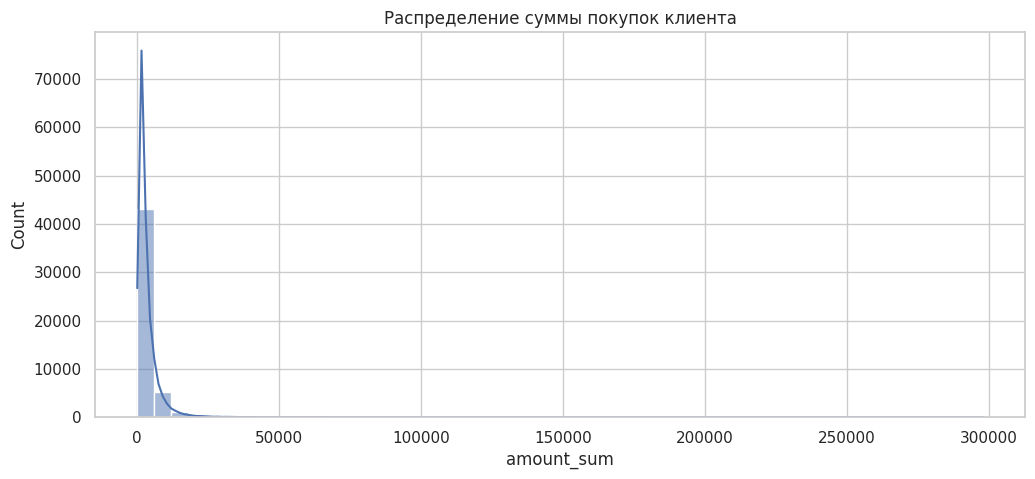

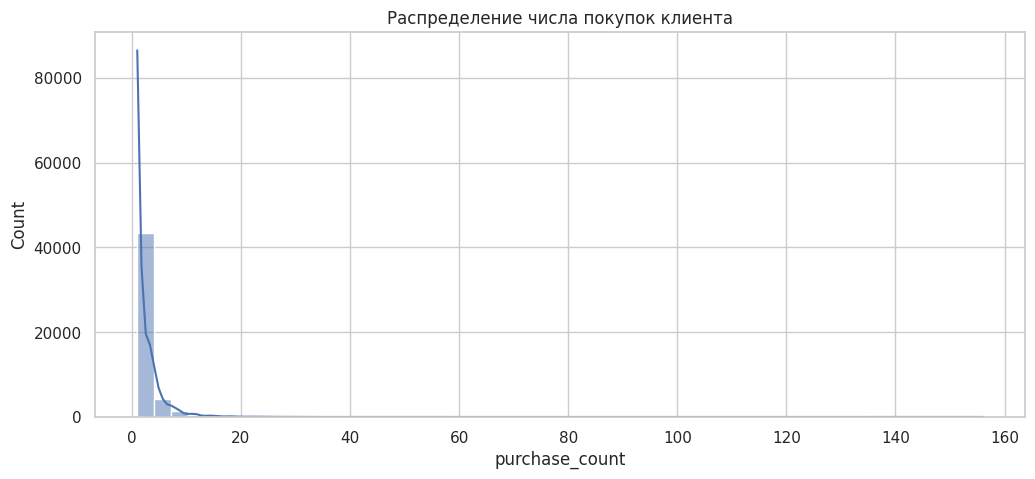

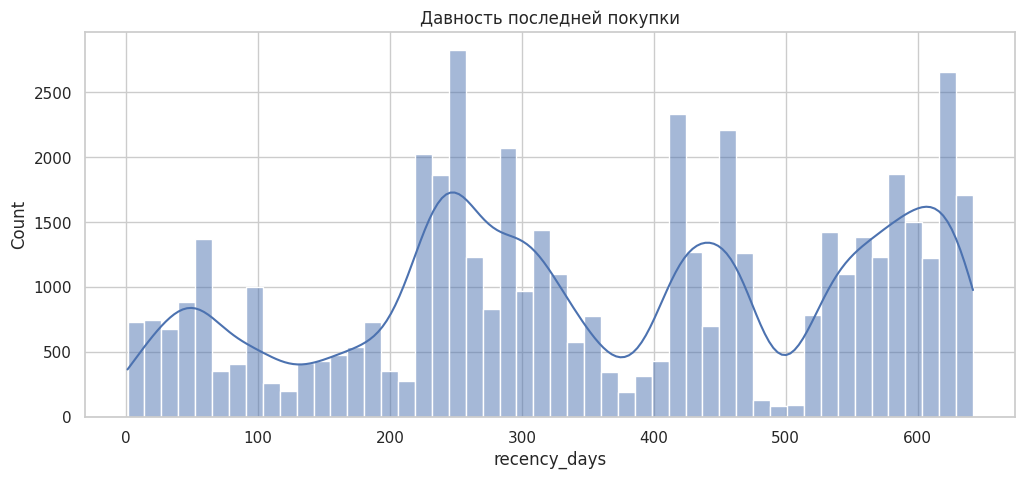

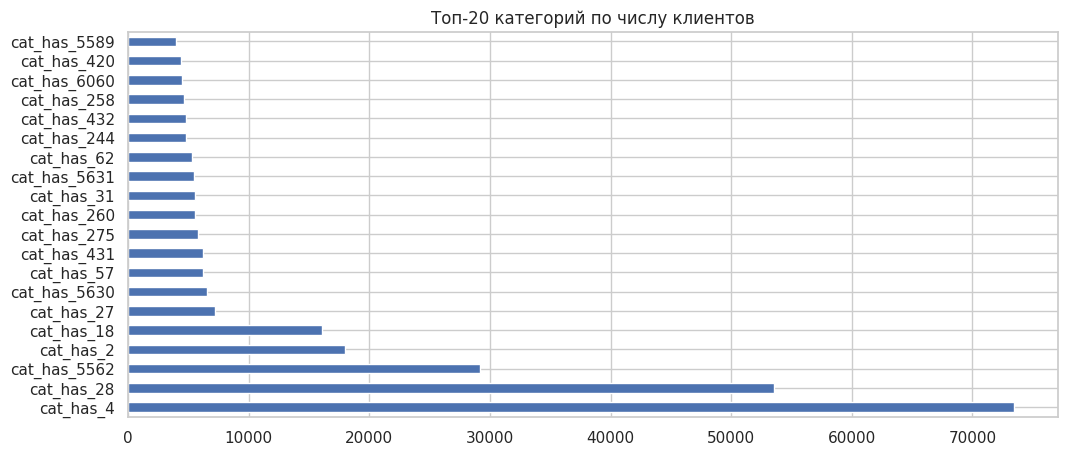

Признаки клиента: (49849, 83)


,client_id,amount_sum,amount_mean,amount_std,amount_max,amount_min,amount_median,quantity_sum,quantity_mean,quantity_std,quantity_median,price_mean,price_std,price_max,price_min,cat_depth_mean,cat_depth_max,last_purchase_date,first_purchase_date,recency_days,customer_age_days,purchase_count,unique_category_ids,unique_category_sets,cat_has_4,cat_has_28,cat_has_5562,cat_has_2,cat_has_18,cat_has_27,cat_has_5630,cat_has_57,cat_has_431,cat_has_275,cat_has_260,cat_has_31,cat_has_5631,cat_has_62,cat_has_244,cat_has_432,cat_has_258,cat_has_6060,cat_has_420,cat_has_5589,cat_has_5633,cat_has_290,cat_has_6058,cat_has_421,cat_has_29,cat_has_213,cat_has_441,cat_has_5536,cat_has_657,cat_has_124,cat_has_5634,cat_has_415,cat_has_249,cat_has_324,cat_has_656,cat_has_1822,cat_has_673,cat_has_212,cat_has_343,cat_has_422,cat_has_436,cat_has_425,cat_has_17,cat_has_61,cat_has_326,cat_has_505,cat_has_58,cat_has_49,cat_has_146,cat_has_344,amount_last_30d,qty_last_30d,orders_last_30d,amount_last_60d,qty_last_60d,orders_last_60d,amount_last_90d,qty_last_90d,orders_last_90d
0,1515915625468060902,4795.0000,959.0000,743.6397,1999.0000,199.0000,999.0000,5,1.0000,0.0000,1.0000,959.0000,743.6397,1999.0000,199.0000,4.0000,4,2022-05-27,2022-05-27,631,0,5,13,5,5,3,0,0,0,2,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,1515915625468061003,14135.0000,2355.8333,604.7844,3499.0000,1749.0000,2169.5000,6,1.0000,0.0000,1.0000,2355.8333,604.7844,3499.0000,1749.0000,4.0000,4,2023-01-04,2023-01-04,409,0,6,4,1,6,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,1515915625468061099,299.0000,299.0000,0.0000,299.0000,299.0000,299.0000,1,1.0000,0.0000,1.0000,299.0000,0.0000,299.0000,299.0000,4.0000,4,2022-05-17,2022-05-17,641,0,1,4,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,1515915625468061100,1049.0000,1049.0000,0.0000,1049.0000,1049.0000,1049.0000,1,1.0000,0.0000,1.0000,1049.0000,0.0000,1049.0000,1049.0000,4.0000,4,2024-02-10,2024-02-10,7,0,1,4,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1049.0000,1.0000,1.0000,1049.0000,1.0000,1.0000,1049.0000,1.0000,1.0000
4,1515915625468061170,14102.0000,1762.7500,871.8202,2699.0000,7.0000,2194.5000,8,1.0000,0.0000,1.0000,1762.7500,871.8202,2699.0000,7.0000,3.5000,4,2023-06-17,2023-03-26,245,83,8,10,4,6,6,0,1,1,0,0,0,0,0,5,0,0,0,1,1,1,0,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [13]:
plt.figure(figsize=(12,5))
sns.histplot(client_agg['amount_sum'], bins=50, kde=True)
plt.title('Распределение суммы покупок клиента')
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(client_agg['purchase_count'], bins=50, kde=True)
plt.title('Распределение числа покупок клиента')
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(client_agg['recency_days'], bins=50, kde=True)
plt.title('Давность последней покупки')
plt.show()

# Топ-20 категорий по числу клиентов
top_cats = [c for c in client_agg.columns if c.startswith('cat_has_')]
plt.figure(figsize=(12,5))
client_agg[top_cats].sum().sort_values(ascending=False).head(20).plot(kind='barh')
plt.title('Топ-20 категорий по числу клиентов')
plt.show()

print("Признаки клиента:", client_agg.shape)
client_agg.head()


In [14]:
if messages is not None:
    print('\nТипы событий в messages:', messages['event'].unique())
    print('Каналы рассылки:', messages['channel'].unique())


msg_agg = messages.groupby(['client_id','event']).size().unstack(fill_value=0).reset_index()
msg_total = messages.groupby('client_id').size().reset_index(name='msg_total_events')
msg_nunique = messages.groupby('client_id')['message_id'].nunique().reset_index(name='msg_nunique_message_ids')
msg_first = messages.groupby('client_id')['date'].min().reset_index(name='msg_first_date')
msg_last = messages.groupby('client_id')['date'].max().reset_index(name='msg_last_date')


msg_features = msg_total.merge(msg_nunique, on='client_id', how='left')
msg_features = msg_features.merge(msg_agg, on='client_id', how='left')
msg_features = msg_features.merge(msg_first, on='client_id', how='left')
msg_features = msg_features.merge(msg_last, on='client_id', how='left')
msg_features['msg_recency_days'] = (snapshot_date - msg_features['msg_last_date']).dt.days
msg_features.fillna(0, inplace=True)


Типы событий в messages: ['open' 'click' 'purchase' 'send' 'unsubscribe' 'hbq_spam' 'hard_bounce'
 'subscribe' 'soft_bounce' 'complain' 'close']
Каналы рассылки: ['email' 'mobile_push']


In [15]:
client_agg = client_agg.merge(msg_features.drop(columns=['msg_first_date','msg_last_date']), on='client_id', how='left')
client_agg.fillna(0, inplace=True)
print(client_agg.shape)

(49849, 97)


In [16]:
client_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 97 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   client_id                49849 non-null  int64         
 1   amount_sum               49849 non-null  float64       
 2   amount_mean              49849 non-null  float64       
 3   amount_std               49849 non-null  float64       
 4   amount_max               49849 non-null  float64       
 5   amount_min               49849 non-null  float64       
 6   amount_median            49849 non-null  float64       
 7   quantity_sum             49849 non-null  int64         
 8   quantity_mean            49849 non-null  float64       
 9   quantity_std             49849 non-null  float64       
 10  quantity_median          49849 non-null  float64       
 11  price_mean               49849 non-null  float64       
 12  price_std                49849 n

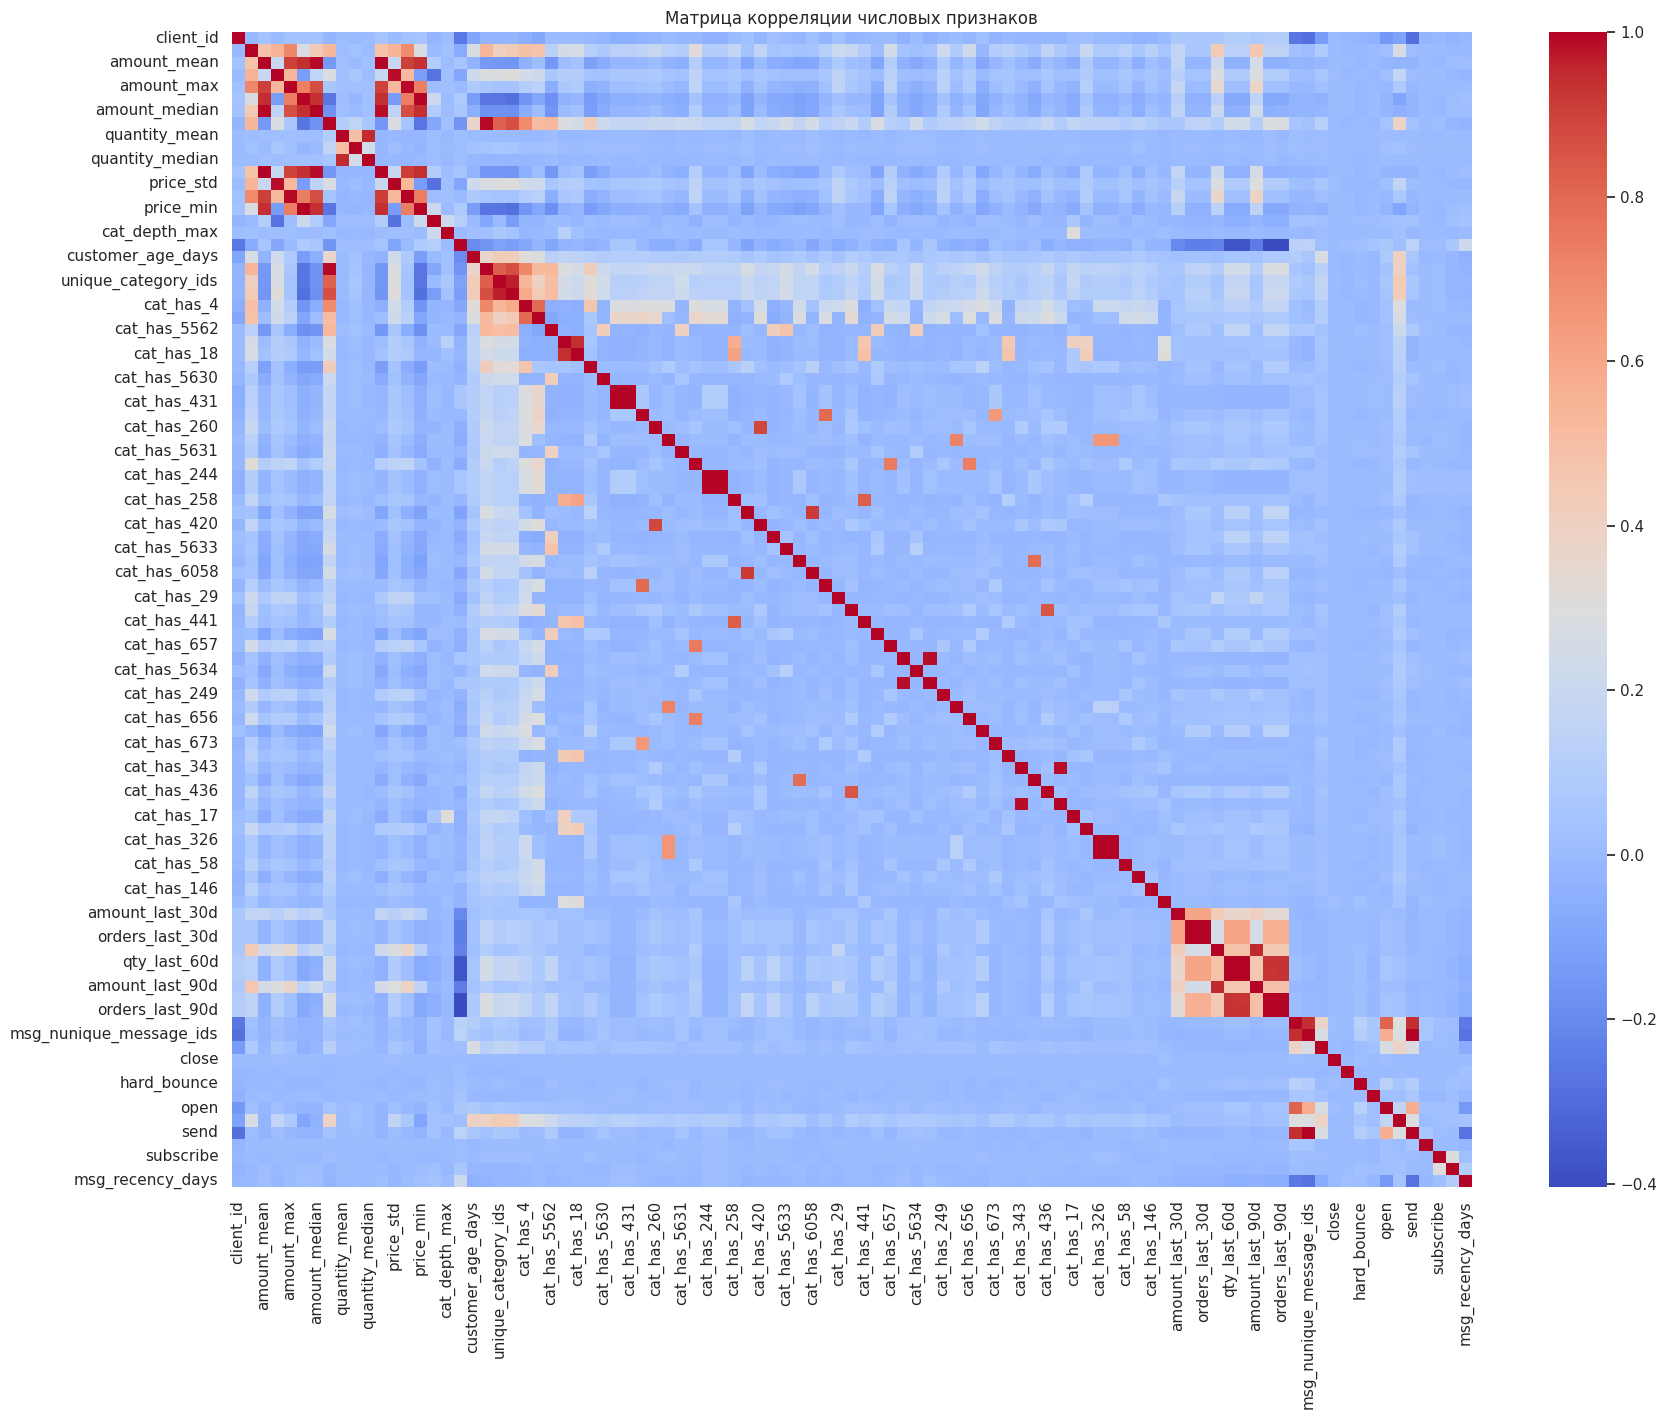

In [17]:
# Выбираем только числовые признаки для корреляции
numeric_cols = client_agg.select_dtypes(include=['int64','float64','Int64','Float64']).columns
corr_matrix = client_agg[numeric_cols].corr()

# Размер фигуры
plt.figure(figsize=(20,15))

# Тепловая карта корреляций
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Матрица корреляции числовых признаков')
plt.show()

Много корреллирующих фичей, сократим размерность с помощью PCA

## Сокращение размерности 

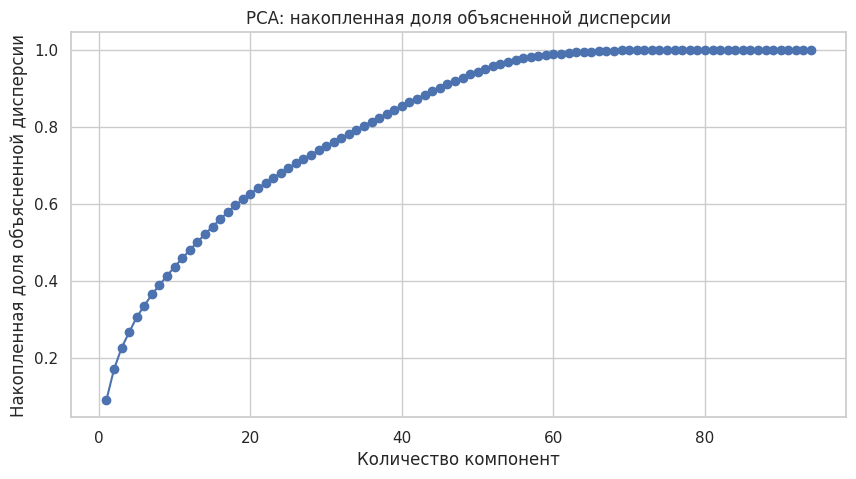

Выбираем 45 компонент для PCA
Форма итогового датасета: (49849, 46)


,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,client_id
0,3.1371,-1.5199,-3.1316,-1.1750,-1.1035,-0.7678,-0.7693,-0.9625,0.3100,-0.3385,-2.4840,0.8366,-2.0978,-0.5720,-3.3296,-1.2495,2.0037,-1.3364,0.1163,-1.2446,2.3336,0.6232,-0.1235,-0.0015,-0.0753,0.1273,0.4194,-0.4897,-0.7044,0.0873,0.2850,-0.2358,0.0383,-0.3113,0.2421,0.3239,0.4856,-0.2161,0.1175,0.6061,-0.2533,-0.2598,-0.3433,-0.0083,-0.3921,1515915625468060902
1,2.4063,2.8805,-2.2595,-1.5934,-1.5925,-0.5177,-0.6523,1.2641,0.4794,0.1354,0.2550,0.5037,0.0052,0.0250,0.1644,-0.0906,0.5950,0.0295,0.1430,-0.6108,-1.4444,2.2746,0.1853,-0.7484,-1.2139,2.0575,-0.4932,11.4014,0.0175,2.6476,1.2176,3.0349,1.9477,-1.4461,0.3056,0.9195,-5.9537,-5.8022,0.8879,-1.6673,2.9840,-6.1615,5.1800,2.2143,0.7336,1515915625468061003
2,-1.9365,-2.1246,0.3059,0.6224,-0.7221,-0.6523,0.0957,0.1902,0.3457,0.0271,-0.1659,0.3937,-0.3784,-0.3383,-0.6124,-0.5451,1.3513,0.4782,-0.1437,0.1037,0.3517,-0.0957,0.2028,0.8323,0.6335,-0.1760,0.8726,0.2749,0.4451,0.4626,-0.0445,0.1201,-0.0451,-0.2694,-0.4922,-0.5317,0.2246,-0.0177,0.1754,-0.6203,0.4806,0.4294,0.1276,0.1152,-0.0533,1515915625468061099
3,-0.1611,-0.6174,2.9819,2.1596,-1.0460,-0.6992,0.5342,-0.1061,-0.1589,-0.0379,0.0211,0.3402,-0.1530,0.0136,0.0338,-0.0318,0.1318,0.0872,0.1185,-0.5006,-0.5456,0.7758,0.0871,0.3656,0.1751,-0.0466,-0.5018,-0.1527,0.3589,0.3603,0.2009,0.0876,-0.3015,-0.0746,-0.0874,-0.1995,0.3592,-0.1864,0.5568,-0.4649,0.4746,0.2034,0.0304,0.0968,-0.2674,1515915625468061100
4,6.0710,0.2568,-4.3243,-0.5903,0.2006,-4.2101,0.1290,1.6924,-4.4185,-0.8983,-3.9634,-3.0054,-4.0543,-0.7851,-6.6766,5.5330,-0.1239,-9.9465,-0.2779,0.5450,-0.2260,-1.3927,0.8552,-0.1893,-0.1886,-0.7733,-0.2036,-0.6703,-0.4062,-0.1189,0.3406,0.0461,0.5064,-0.1990,-0.2338,0.1823,0.0048,-0.2652,0.2785,0.2608,0.0593,0.2737,-0.0255,-0.2229,0.1806,1515915625468061170


In [18]:
# Сохраняем client_id отдельно
client_ids = client_agg['client_id']

# Убираем client_id и datetime
X = client_agg.drop(columns=['client_id', 'last_purchase_date', 'first_purchase_date'])
X.fillna(0, inplace=True)

# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Накопленная доля объясненной дисперсии
cumulative_var = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(10,5))
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o')
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная доля объясненной дисперсии')
plt.title('PCA: накопленная доля объясненной дисперсии')
plt.grid(True)
plt.show()

# Выбираем число компонент, объясняющих 90% дисперсии
n_components = (cumulative_var < 0.90).sum() + 1
print(f'Выбираем {n_components} компонент для PCA')

# Финальная PCA
pca_final = PCA(n_components=n_components)
X_reduced = pca_final.fit_transform(X_scaled)

# Итоговый DataFrame для модели, client_id сохраняем
pca_df = pd.DataFrame(X_reduced, columns=[f'pca_{i+1}' for i in range(n_components)])
pca_df['client_id'] = client_ids.values

print('Форма итогового датасета:', pca_df.shape)
pca_df.head()


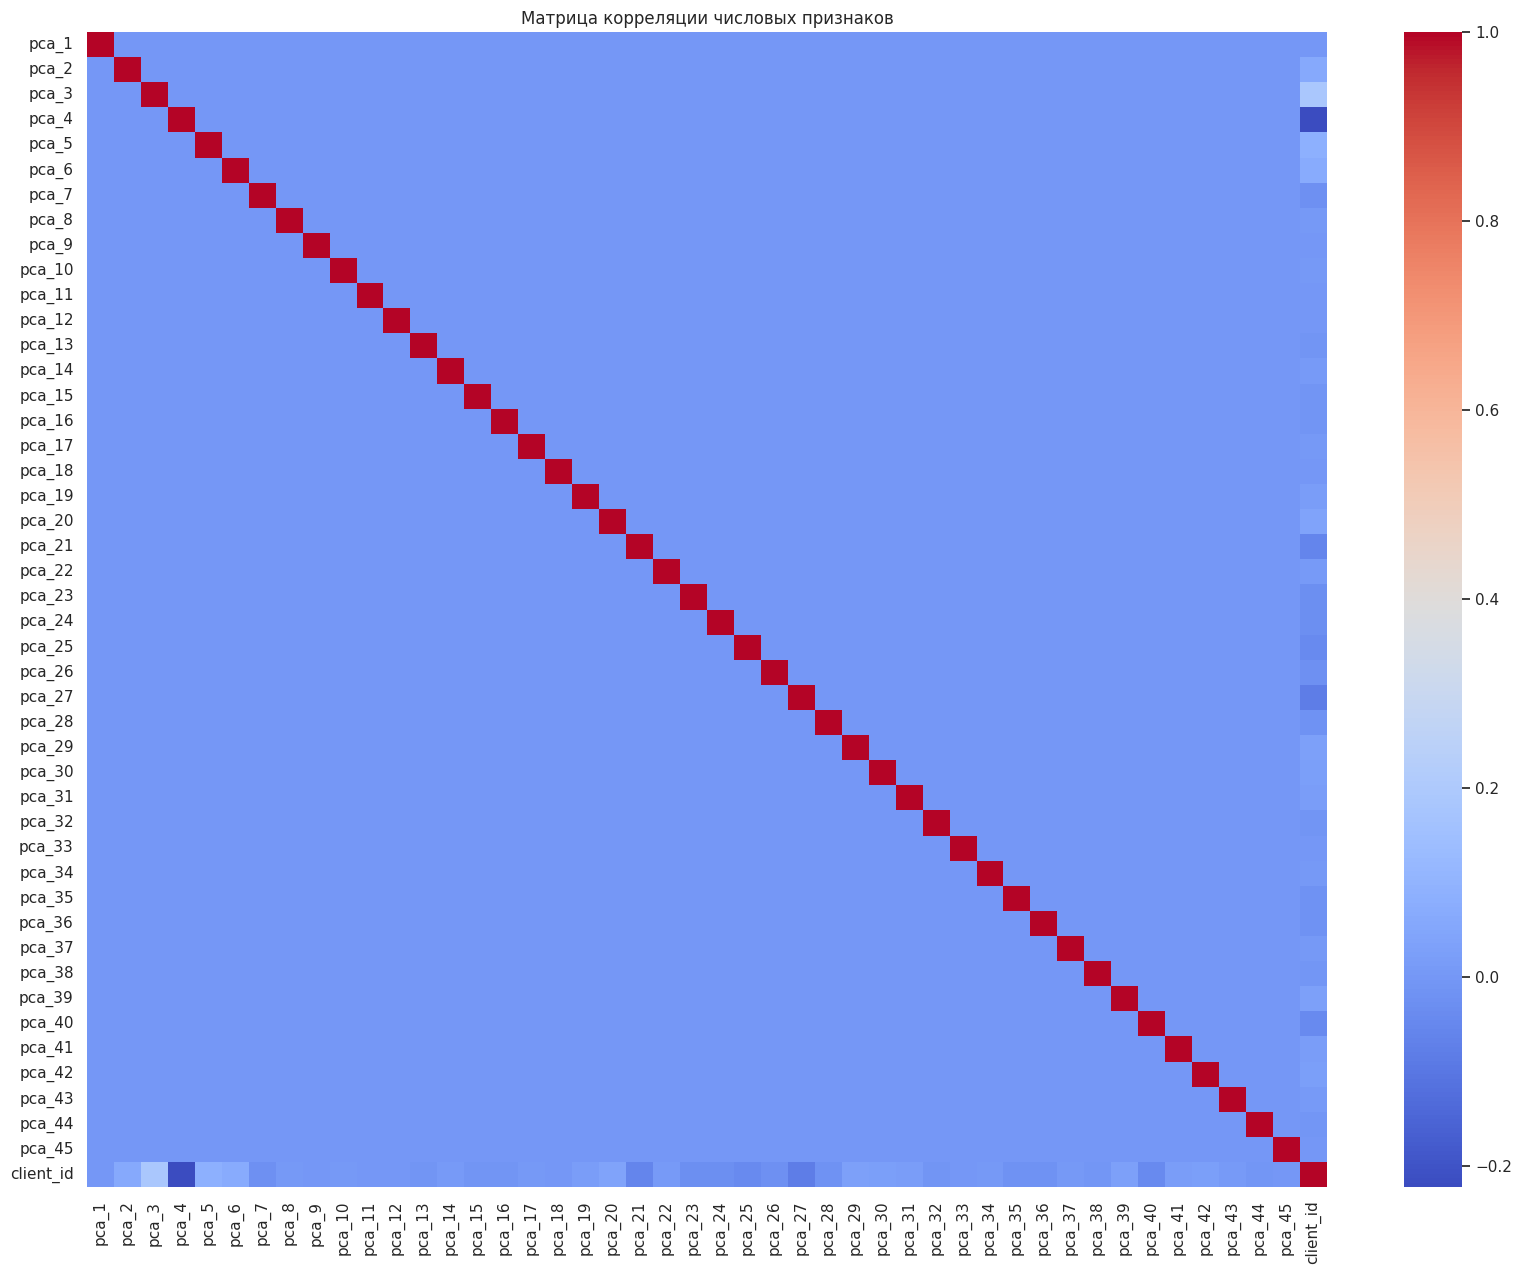

In [19]:
# Выбираем только числовые признаки для корреляции
numeric_cols = pca_df.select_dtypes(include=['int64','float64','Int64','Float64']).columns
corr_matrix = pca_df[numeric_cols].corr()

# Размер фигуры
plt.figure(figsize=(20,15))

# Тепловая карта корреляций
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Матрица корреляции числовых признаков')
plt.show()

Идеальная матрица, переходим к обучению

# Обучение моделей

In [20]:
target = target.rename(columns={target.columns[0]:'client_id', target.columns[1]:'target'})


df = pca_df.merge(target, on='client_id', how='left')
print('\nФинальный датасет:', df.shape)
print('Распределение target:\n', df['target'].value_counts(dropna=False))


df = df.dropna(subset=['target'])
y = df['target'].astype(int)
X = df.drop(columns=['client_id','target'])


feature_cols = X.columns.tolist()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Размеры train/test:', X_train.shape, X_test.shape)


Финальный датасет: (49849, 47)
Распределение target:
 target
0    48888
1      961
Name: count, dtype: int64
Размеры train/test: (39879, 45) (9970, 45)


In [21]:
print(y_test.value_counts())

target
0    9778
1     192
Name: count, dtype: int64


## RandomForest

In [22]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])


preprocessor = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])


baseline_clf = Pipeline(steps=[('preproc', preprocessor), 
                               ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])


param_dist = {
    'clf__n_estimators': [100,200,400],
    'clf__max_depth': [5,10,20,None],
    'clf__min_samples_split': [2,5,10],
    'clf__min_samples_leaf': [1,2,5]
}


search = RandomizedSearchCV(
    baseline_clf,
    param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
    )


search.fit(X_train, y_train)
print('Лучшие параметры:', search.best_params_)
print('Лучший AUC на CV:', search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Лучшие параметры: {'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 5, 'clf__max_depth': 10}
Лучший AUC на CV: 0.7031624226207377


Лучший порог для precision: 0.26, precision = 0.5000
AUC на тесте: 0.7171
Accuracy на тесте: 0.9807
Precision на тесте: 0.5000


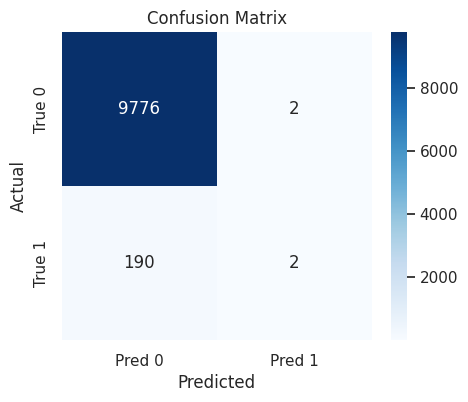

In [23]:
best_model = search.best_estimator_

# Прогнозы вероятностей
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# --- Оптимизация порога для максимизации precision ---
precisions = []
thresholds = np.arange(0.1, 1.0, 0.01)
for thr in thresholds:
    preds_thr = (y_pred_proba >= thr).astype(int)
    precisions.append(precision_score(y_test, preds_thr, zero_division=0))

best_thr = thresholds[np.argmax(precisions)]
print(f"Лучший порог для precision: {best_thr:.2f}, precision = {max(precisions):.4f}")

# Применяем оптимальный порог
y_pred = (y_pred_proba >= best_thr).astype(int)

# --- Метрики ---
auc_best = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)

print(f"AUC на тесте: {auc_best:.4f}")
print(f"Accuracy на тесте: {acc:.4f}")
print(f"Precision на тесте: {prec:.4f}")

# --- Матрица ошибок ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# CatBoost

In [24]:
catboost_model = CatBoostClassifier(
    eval_metric="AUC",
    random_seed=42,
    verbose= 0,       
)

param_dist_cat = {
    'iterations': [200, 400, 600],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 10]
}

search_cat = RandomizedSearchCV(
    catboost_model,
    param_distributions=param_dist_cat,
    n_iter=10,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=1,  
    verbose=1
)
search_cat.fit(X_train, y_train, cat_features=cat_cols)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7a808993bd50>,
                   n_jobs=1,
                   param_distributions={'depth': [4, 6, 8, 10],
                                        'iterations': [200, 400, 600],
                                        'l2_leaf_reg': [1, 3, 5, 7, 10],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.2]},
                   random_state=42, scoring='roc_auc', verbose=1)

Лучший порог для precision: 0.25, precision = 1.0000
AUC на тесте: 0.7321
Accuracy на тесте: 0.9808
Precision на тесте: 1.0000


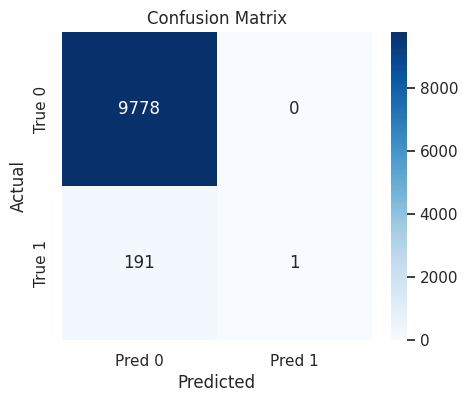

In [25]:
best_model = search_cat.best_estimator_

# Прогнозы вероятностей
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# --- Оптимизация порога для максимизации precision ---
precisions = []
thresholds = np.arange(0.1, 1.0, 0.01)
for thr in thresholds:
    preds_thr = (y_pred_proba >= thr).astype(int)
    precisions.append(precision_score(y_test, preds_thr, zero_division=0))

best_thr = thresholds[np.argmax(precisions)]
print(f"Лучший порог для precision: {best_thr:.2f}, precision = {max(precisions):.4f}")

# Применяем оптимальный порог
y_pred = (y_pred_proba >= best_thr).astype(int)

# --- Метрики ---
auc_best = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)

print(f"AUC на тесте: {auc_best:.4f}")
print(f"Accuracy на тесте: {acc:.4f}")
print(f"Precision на тесте: {prec:.4f}")

# --- Матрица ошибок ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()